In [14]:
import pandas as pd
from causallearn.utils.FastKCI.FastKCI import FastKCI_CInd, FastKCI_UInd
from causallearn.utils.KCI.KCI import KCI_CInd, KCI_UInd
from causallearn.utils.RCIT.RCIT import RIT, RCIT
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, Matern,RationalQuadratic, WhiteKernel, DotProduct
from hyppo.independence import Hsic
from src.fcit.fcit import fcit
from prettytable import PrettyTable
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
import warnings
warnings.simplefilter("ignore") 
import matplotlib.pyplot as plt


In [26]:
def instrumental_variable(A, W):
    iv_model = RandomForestRegressor().fit(y=A.squeeze(), X=W)
    A_hat = iv_model.predict(W)
    return np.expand_dims(A_hat, axis=1)

class FIT(object):
    def __init__(self):
        pass
    def compute_pvalue(self, x,y, z=None):
        p_value = fcit.test(x,y,z)
        return (p_value, None)
    
class GP_HSIC(object):
    def __init__(self):
        pass
    def compute_pvalue_noniid(self, x,y,s,z=None):
        normalize = True
        # GP regressions of X,Y,Z onto S to obtain residuals
        #kernel = Matern(nu=1.5)
        kernel = RBF(length_scale=1.0) #C(1.0) * RBF(length_scale=1.0)
        gp_x = GaussianProcessRegressor(kernel=kernel, normalize_y=normalize)
        gp_x.fit(s, x)
        r_x = x - gp_x.predict(s)
        gp_y = GaussianProcessRegressor(kernel=kernel, normalize_y=normalize)
        gp_y.fit(s, y)
        r_y = y -  gp_y.predict(s)

        
        if z is not None:
            #kernel = C(1.0) * RBF(length_scale=1.0) # TODO, how to choose kernel 
            # GP regression of residuals onto Z to obtain additional residuals
            gp_z = GaussianProcessRegressor(kernel=kernel, normalize_y=normalize)
            gp_z.fit(s, z)
            r_z = z - gp_z.predict(s)
        
            gp_rxz = GaussianProcessRegressor(kernel=kernel, normalize_y=normalize)
            gp_rxz.fit(r_z, r_x)
            r_xz = r_x - gp_rxz.predict(r_z)
            gp_ryz = GaussianProcessRegressor(kernel=kernel, normalize_y=normalize)
            gp_ryz.fit(r_z, r_y)
            r_yz = r_y - gp_ryz.predict(r_z)
        else:
            # If not conditional, resort to normal independece test of residuals
            r_xz = r_x
            r_yz = r_y
            
        # HSIC test of residuals
        stat, pval = Hsic().test(r_xz, r_yz)
        return (pval, stat)
        

    def compute_pvalue(self, x,y,z=None):
        kernel = RBF(length_scale=1.0) #RBF(length_scale=1.0)+ WhiteKernel(noise_level=0.1) # TODO, how to choose kernel 
        
        if z is not None:
            # GP regression to obtain residuals of X,Y onto Z
            gp_xz = GaussianProcessRegressor(kernel=kernel, normalize_y=True,)
            gp_xz.fit(z, x)
            r_x = x - gp_xz.predict(z)
            gp_yz = GaussianProcessRegressor(kernel=kernel, normalize_y=True)
            gp_yz.fit(z, y)
            r_y = y - gp_yz.predict(z)
        else:
            # If not conditional, revert to regular independence test
            r_x = x
            r_y = y
            
        # HSIC test for independence
        stat, pval = Hsic().test(r_x, r_y)
        return (pval, stat)    
    
def run_evidence_test(df, edge, evidence, test='randomized', iv=False):
    test_indirect, test_direct = None, None
    path_length = len(evidence) # including endpoints
    #if path_length == 3:
    if test == 'RCIT':
        test_indirect = RCIT()
        test_direct = RIT()
    elif test == 'KCIT':
        test_indirect = KCI_CInd(use_gp=True)
        test_direct = KCI_UInd()
    elif test== 'FastKCIT':
        test_indirect = FastKCI_CInd()
        test_direct = FastKCI_UInd()
    elif test == 'FIT':
        test_indirect = FIT()
        test_direct = FIT()
    elif test == "GP_HSIC":
        test_indirect = GP_HSIC()
        test_direct = GP_HSIC()
    else:
        print(f"Unsupported CI test {test}")
    A = edge[0]
    B = edge[1]
    I = evidence[1:path_length-1]
    # print(evidence, I)
    d_A = np.expand_dims(df[A].to_numpy(), axis=1)
    d_B =  np.expand_dims(df[B].to_numpy(), axis=1)
    d_I = df[I].to_numpy()
    # if len(I) == 1:
    #     d_I =  np.expand_dims(d_I, axis=1)
    d_A = np.log1p(d_A)
    d_I = np.log1p(d_I)
    d_B = np.log1p(d_B)
    if iv:
        d_W = np.expand_dims(df['radiation'].to_numpy(), axis=1)
        if test == 'GP_HSIC':
            p_direct = test_direct.compute_pvalue_noniid(x=d_A, y=d_B, s=d_W)[0]
            p_indirect = test_indirect.compute_pvalue_noniid(x=d_A, y=d_B, z=d_I, s=d_W)[0] 
        else:
            d_A = instrumental_variable(d_A, d_W)
            p_direct = test_direct.compute_pvalue(d_A, d_B)[0]
            p_indirect = test_indirect.compute_pvalue(d_A, d_B, d_I)[0]
    else:
        p_direct = test_direct.compute_pvalue(d_A, d_B)[0]
        p_indirect = test_indirect.compute_pvalue(d_A, d_B, d_I)[0]    
    
    # if p_direct <=0.05:
    #     test_str = f"Test failed, {A} is dependent to {B} conditioned on the empty set: {p_direct}\n"
    # else:
    #     test_str = f"Test passed, {A} is independent of {B} conditioned on the empty set: {p_direct}\n"
    # if p_indirect <=0.05:
    #     test_str += f"Test failed, {A} is dependent to {B} conditioned on {I}: {p_indirect}"
    # else:
    #     test_str += f"Test passed, {A} is independent of {B} conditioned on {I}: {p_indirect}"
    direct_test = "pass" if p_direct > 0.05 else "fail"
    indirect_test = "pass" if p_indirect > 0.05 else "fail"
    return direct_test, round(p_direct,4), indirect_test, round(p_indirect, 4)
    # else:
    #     return None

In [19]:
def kernel_selection(x, y):
    # x = StandardScaler().fit_transform(x)
    # y = StandardScaler().fit_transform(y.reshape(-1, 1)).ravel()
    x = np.log1p(x)
    y = np.log1p(y) 
    n_features = x.shape[1]
    noise = 1
    kernels = {
        "Matern 1.5": Matern(length_scale=n_features*[1.0], nu=1.5),
        "RBF": RBF(length_scale=n_features*[1.0]),
        "RBF + WhiteKernel": RBF(length_scale=n_features*[1.0]) + WhiteKernel(noise_level=noise),
        "Dot Product": DotProduct(sigma_0=1),

        "Dot Product + White Kernel": DotProduct(sigma_0=1) + WhiteKernel(noise_level=noise),
        "Matern + WhiteKernel": Matern(length_scale=n_features*[1.0], nu=1.5)+ WhiteKernel(noise_level=noise),
        "RationalQuadratic": RationalQuadratic(length_scale=n_features*[1.0], alpha=1.0),

        "RationalQuadratic + WhiteKernel": RationalQuadratic(length_scale=n_features*[1.0], alpha=1.0) + WhiteKernel(noise_level=noise),
    }
    for name, kernel in kernels.items():
        print(name)
        gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=0)
        gpr.fit(x,y)
        scores = cross_val_score(gpr, x, y, scoring='neg_mean_squared_error', cv=5)
        print("CV MSE: %.4f" % (-np.mean(scores)))  
        
        # 4. Predict on test data
        X_test  =np.linspace(np.min(x), np.max(x), 1000).reshape(-1, 1)
        y_pred, y_std = gpr.predict(X_test, return_std=True)
        
        # 5. Cross-Validation MSE
        mse = -np.mean(scores)

        # 6. Plot results
        # plt.figure(figsize=(8, 5))
        # plt.title(f"{name} kernel\nCV MSE: {mse:.4f}, LML: {gpr.log_marginal_likelihood_value_:.2f}")
        # plt.scatter(x, y, c='k', s=15, label='Training data')
        # plt.plot(X_test, y_pred, 'b', label='Prediction')
        # plt.fill_between(X_test.ravel(), y_pred - 2*y_std, y_pred + 2*y_std, alpha=0.2, color='blue', label='95% CI')
        # plt.xlabel("X")
        # plt.ylabel("y")
        # plt.legend()
        # plt.tight_layout()
        # plt.show()

In [20]:
celltype='huvec'
doses = ["A", "B", "C", "D", "E"]
dfs = [pd.read_csv(f"./data/{celltype}/cd_matrix_d{d}.csv", header=0) for d in doses]
df_map = dict(zip(doses, dfs))
df_consensus_w_edges =  pd.read_csv(f"./data/{celltype}/consensus_edges_w_indirect_evidence.csv", header=0)

In [27]:
ci_tests = ["KCIT",  "RCIT", "GP_HSIC"] #"FastKCIT",
iv_variable = [True, False]
for ci_test in ci_tests:
    for iv in iv_variable:
        table=PrettyTable()
        table.field_names = ["Edge (A,B)", 
                            "Evidence (A,I,B)", 
                            "A indep B (pvalue)", "A indep B | I (pvalue)", "Support"]
        table.title = f"{ci_test} (IV radiation: {iv})"
        for _, row in df_consensus_w_edges.iterrows():
            if row['evidence'] != 'true positive':
                edge = (row['TF'], row['target'])
                evidence = row['evidence'].replace("'", "").replace("[", "").replace("]", "").replace(" ", "").split(",")
                df = df_map[row['dose']]
                output = run_evidence_test(df, edge, evidence, test=ci_test, iv=iv)
                if output is not None:
                    test_direct, direct_pvalue, test_indirect, indirect_pvalue = output
                    if (test_direct=="fail" and test_indirect == "pass"):
                        support = "indirect"
                    elif (test_direct=="fail" and test_indirect == "fail"):
                        support = "direct"
                    else:
                        support = "inconclusive"
                    table.add_row([edge, evidence,f"{test_direct} ({direct_pvalue})", f"{test_indirect} ({indirect_pvalue})", support])
        print(table)
            


+---------------------------------------------------------------------------------------------------------------------------+
|                                                 KCIT (IV radiation: True)                                                 |
+---------------------+----------------------------------------+--------------------+------------------------+--------------+
|      Edge (A,B)     |            Evidence (A,I,B)            | A indep B (pvalue) | A indep B | I (pvalue) |   Support    |
+---------------------+----------------------------------------+--------------------+------------------------+--------------+
|  ('EGR2', 'CDC27')  |  ['EGR2', 'TP53', 'CDKN1A', 'CDC27']   |   pass (0.3631)    |     pass (0.1975)      | inconclusive |
|   ('EGR2', 'CFL1')  |        ['EGR2', 'TP53', 'CFL1']        |   pass (0.5021)    |     pass (0.2601)      | inconclusive |
|   ('EGR2', 'ID1')   |        ['EGR2', 'TP53', 'ID1']         |    pass (0.328)    |     pass (0.4574)      | inconcl

(0.21260910608869, 0.0024995802919402354)
Matern 1.5
CV MSE: 1.4283


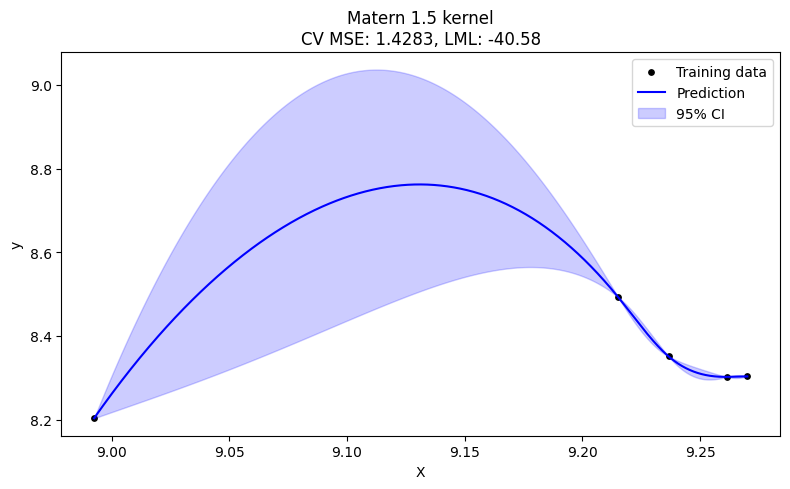

RBF
CV MSE: 13.0245


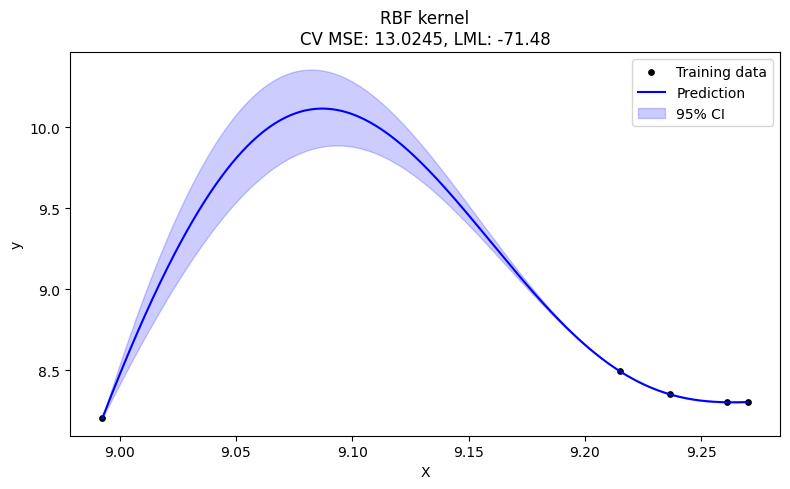

RBF + WhiteKernel
CV MSE: 61.2731


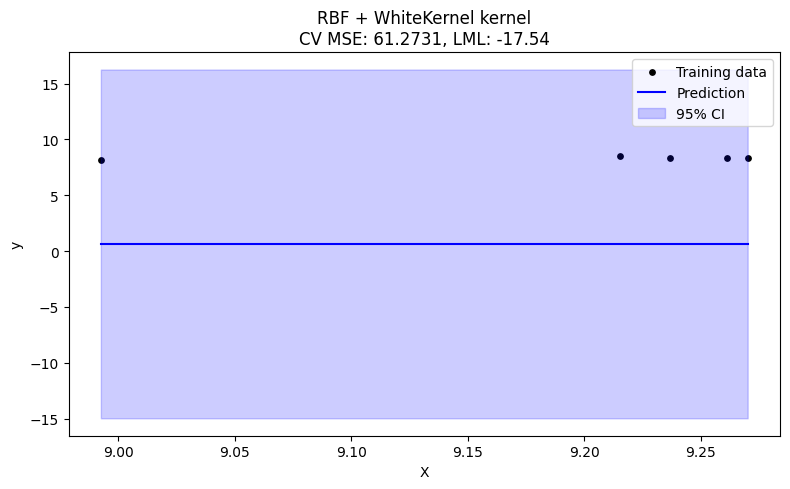

Dot Product
CV MSE: 0.2178


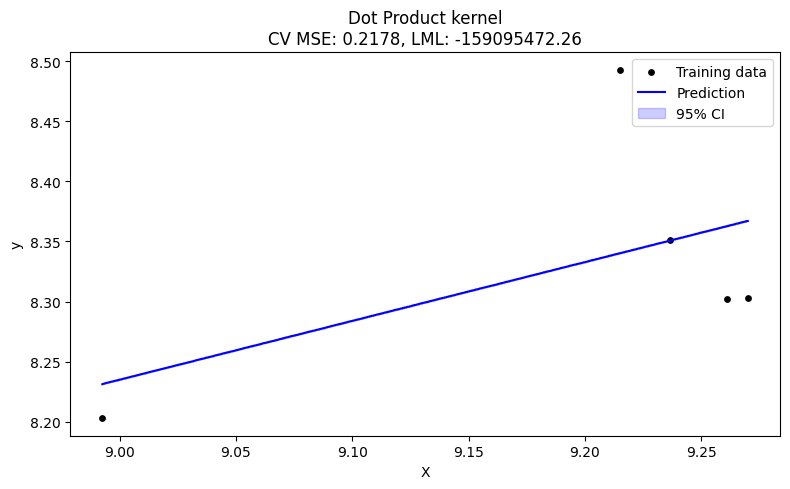

Dot Product + White Kernel
CV MSE: 0.0196


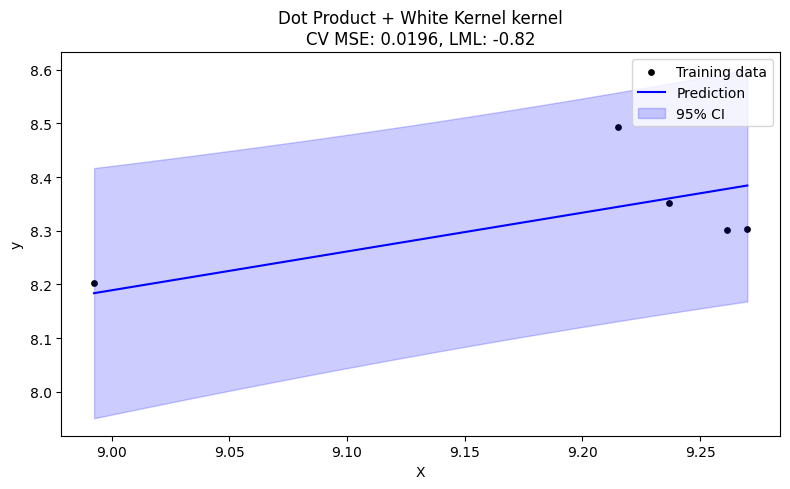

Matern + WhiteKernel
CV MSE: 61.2731


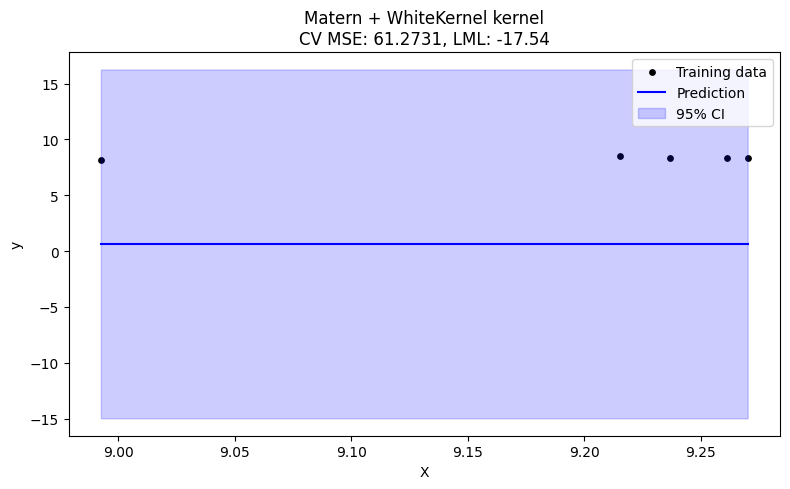

RationalQuadratic
CV MSE: 0.0050


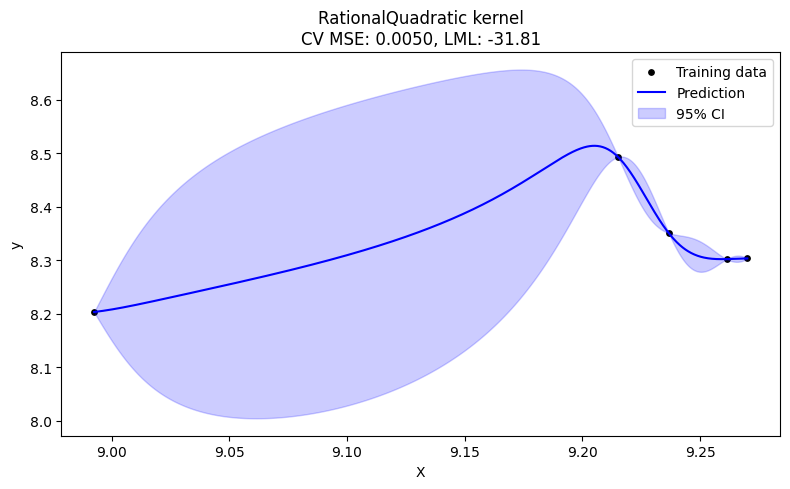

RationalQuadratic + WhiteKernel
CV MSE: 61.2731


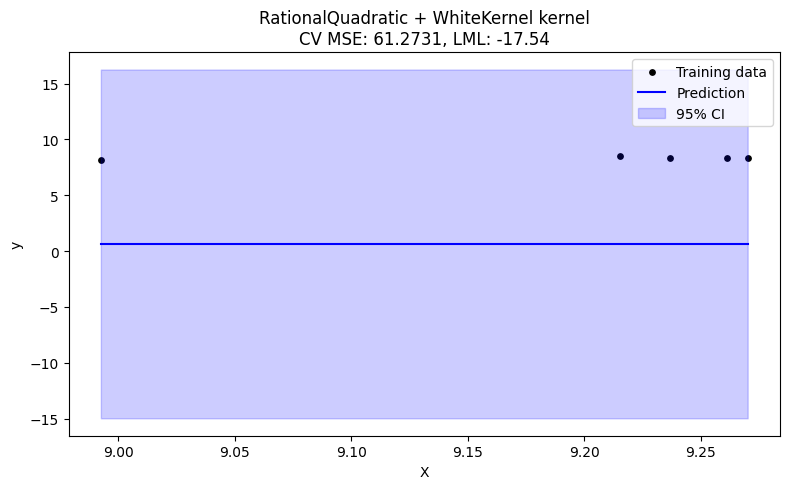

In [8]:
# test_edge =  ['EGR2', 'TP53', 'CFL1']
test_edge = ('EGR2', 'ARIH2')
for _, row in df_consensus_w_edges.iterrows():
    df = df_map[row['dose']]
    edge = (row['TF'], row['target'])
    if edge == test_edge: 
        A = edge[0]
        B = edge[1]
        I = 'TP53'
        d_A = np.expand_dims(df[A].iloc[8:].to_numpy(), axis=1)
        d_B =  np.expand_dims(df[B].iloc[8:].to_numpy(), axis=1)
        d_I =  np.expand_dims(df[I].iloc[8:].to_numpy(), axis=1)
        test = KCI_CInd(use_gp=False)
        print(test.compute_pvalue(d_A, d_B, d_I))
        kernel_selection(d_I, d_B)

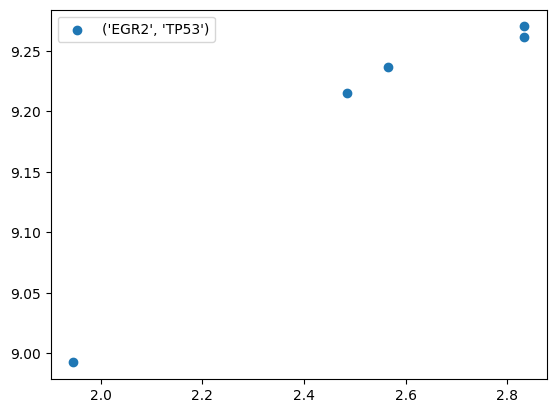

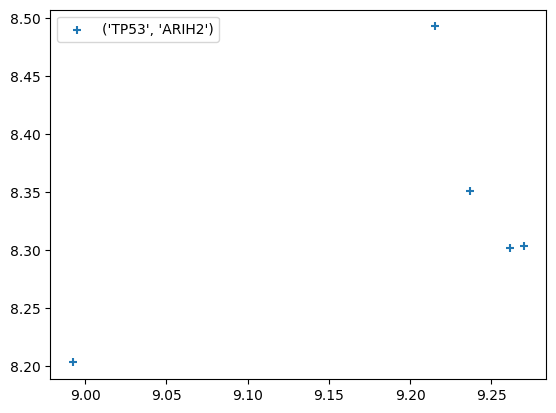

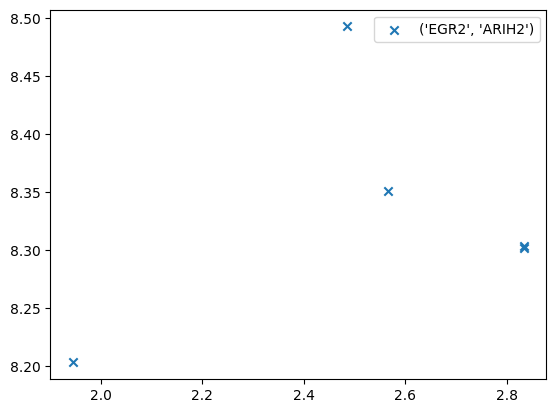

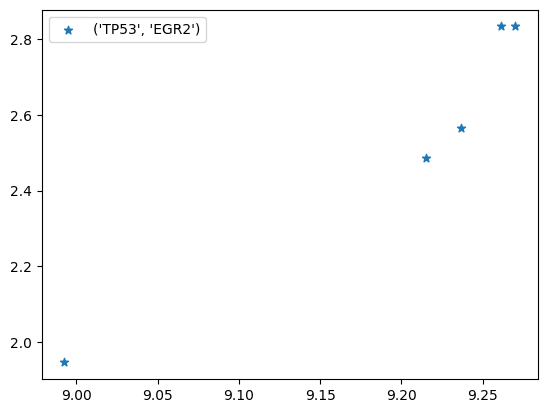

In [11]:
x = np.log1p(d_A) #StandardScaler().fit_transform(d_A)
y = np.log1p(d_B) #StandardScaler().fit_transform(d_B)
i =  np.log1p(d_I) #StandardScaler().fit_transform(d_I)
plt.scatter(x,i, label="('EGR2', 'TP53')", marker='o')
plt.legend()
plt.show()
plt.scatter(i,y, label="('TP53', 'ARIH2')", marker='+')
plt.legend()
plt.show()
plt.scatter(x,y, label="('EGR2', 'ARIH2')", marker='x')
plt.legend()
plt.show()
plt.scatter(i,x, label="('TP53', 'EGR2')", marker='*')
plt.legend()
plt.show()


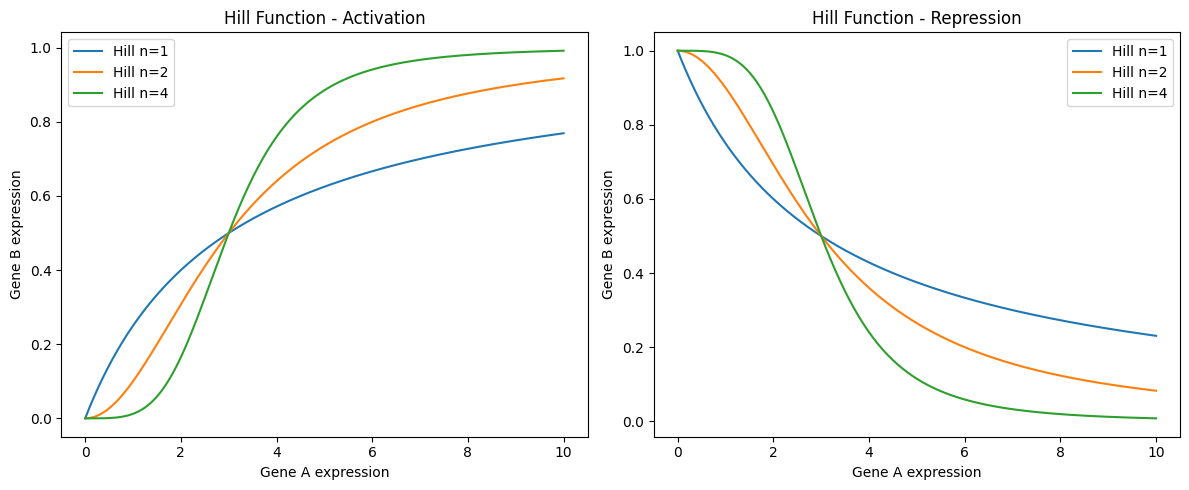

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Gene A expression range
A = np.linspace(0, 10, 500)

# Parameters
Vmax = 1.0
Kd = 3.0  # half-max activation
n_vals = [1, 2, 4]  # Hill coefficients for cooperativity

plt.figure(figsize=(12, 5))

# Plot activation
plt.subplot(1, 2, 1)
for n in n_vals:
    B_activation = (Vmax * A**n) / (Kd**n + A**n)
    plt.plot(A, B_activation, label=f"Hill n={n}")
plt.title("Hill Function - Activation")
plt.xlabel("Gene A expression")
plt.ylabel("Gene B expression")
plt.legend()

# Plot repression
plt.subplot(1, 2, 2)
for n in n_vals:
    B_repression = Vmax / (1 + (A / Kd)**n)
    plt.plot(A, B_repression, label=f"Hill n={n}")
plt.title("Hill Function - Repression")
plt.xlabel("Gene A expression")
plt.ylabel("Gene B expression")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
df = pd.read_csv("paths_EGR2_BTG2.csv")
print(df.shape)


         Unnamed: 0     0     1     2       3       4     5     6     7    8  \
0                 0  EGR2  EGR1  TP53    BTG2     NaN   NaN   NaN   NaN  NaN   
1                 1  EGR2  EGR1   MYC   TAF10    TP53  BTG2   NaN   NaN  NaN   
2                 2  EGR2  EGR1   MYC  ELAVL1    TP53  BTG2   NaN   NaN  NaN   
3                 3  EGR2  EGR1   MYC    CHUK    TP53  BTG2   NaN   NaN  NaN   
4                 4  EGR2  EGR1   MYC    RNF4  CDKN1A   SET  TP53  BTG2  NaN   
...             ...   ...   ...   ...     ...     ...   ...   ...   ...  ...   
6555249     6555249  EGR2  HIRA   MYC  TUBB4B    TP53  BTG2   NaN   NaN  NaN   
6555250     6555250  EGR2  HIRA   MYC  TOMM20    TP53  BTG2   NaN   NaN  NaN   
6555251     6555251  EGR2  HIRA   MYC  RECQL4    TP53  BTG2   NaN   NaN  NaN   
6555252     6555252  EGR2  HIRA   MYC  PDLIM7    TP53  BTG2   NaN   NaN  NaN   
6555253     6555253  EGR2  HIRA  TP53    BTG2     NaN   NaN   NaN   NaN  NaN   

           9   10  
0        NaN  NaN  

In [13]:
import numpy as np
print(df.columns)
df_path_5 = df[df['6'].isna()]
print(df.shape,df_path_5.shape)

Index(['Unnamed: 0', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'], dtype='object')
(6555254, 12) (5607, 12)
